# Build state-specific renewable suitablity layers for GRIDCERF


The following code was used to build the state specific renewable suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.57931/2281697.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  Protected Areas Exclusion (Geothermal)
- **Description from Source**: Protected Areas Exclusions are areas in California, identified by California Energy Commission staff as legally protected from geothermal development and excluded from geothermal resource potential calculation in the draft SB100 land-use screen project. A combination of statewide geospatial datasets was combined to create the Protected Areas Exclusion.
- **Source URL**:  https://data.cnra.ca.gov/dataset/protected-areas-exclusion-geothermal/resource/3931dea5-45e6-4bd2-a5bc-bce8ff18616e
- **Date Accessed**:  10/11/23
- **Citation**
> California Energy Commission, 2023. Protected Areas Exclusion (Geothermal).https://data.cnra.ca.gov/dataset/protected-areas-exclusion-geothermal/resource/3931dea5-45e6-4bd2-a5bc-bce8ff18616e (accessed 10/11/23)
- **Application**: All areas indicated in the source data are considered excluded from geothermal development

____

- **Title**:  Protected Areas Exclusion (Solar)
- **Description from Source**: The protected area layer is a composite GIS layer designed to encompass areas where utility-scale renewable energy or transmission development is precluded by state or federal law, policy, or regulation. It draws from several protected areas datasets, local, state or federal land that is designated for other uses, easements, and other similar designations. The protected area layer is combined with the techno-economic exclusion layer to form the base exclusions in the CEC 2023 Land Use Screens.
- **Source URL**:  https://data.cnra.ca.gov/dataset/protected-areas-exclusion-solar
- **Date Accessed**:  10/11/23
- **Citation**
> California Energy Commission, 2023. Protected Areas Exclusion (Solar).https://data.cnra.ca.gov/dataset/protected-areas-exclusion-solar (accessed 10/11/23)
- **Application**: All areas indicated in the source data are considered excluded from solar development
____

- **Title**:  Protected Areas Exclusion (Wind)
- **Description from Source**: Protected Areas Exclusions are areas in California, identified by California Energy Commission staff as legally protected from wind development and excluded from wind resource potential calculation in the draft SB100 land-use screen project. A combination of statewide geospatial datasets was combined to create the Protected Areas Exclusion.
- **Source URL**:  https://cecgis-caenergy.opendata.arcgis.com/datasets/CAEnergy::protected-areas-exclusion-wind/explore?location=37.177856%2C-119.308459%2C7.21
- **Date Accessed**:  10/11/23
- **Citation**
> California Energy Commission, 2023. Protected Areas Exclusion (Wind).https://data.cnra.ca.gov/dataset/protected-areas-exclusion-geothermal/resource/3931dea5-45e6-4bd2-a5bc-bce8ff18616e (accessed 10/11/23)
- **Application**: All areas indicated in the source data are considered excluded from wind development

### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'state_level_renewable_exclusions' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source airports
ca_geothermal_shpfile = os.path.join(source_dir, 'Protected_Areas_Exclusion_(Geothermal)',  "Protected_Areas_Exclusion_(Geothermal).shp")

# shapefile location for the source airports
ca_solar_shpfile = os.path.join(source_dir,'Protected_Areas_Exclusion_(Solar)', "ProtectedAreas_Solar.shp")

# shapefile location for the source airports
ca_wind_shpfile = os.path.join(source_dir, 'Protected_Areas_Exclusion_(Wind)', "ProtectedAreas_Wind.shp")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

#### 4.2.1 California Geothermal Restrictions

In [6]:
# read in shapefile and project to our GRIDCERF projection
gdf = gpd.read_file(ca_geothermal_shpfile).to_crs(crs=crs)

<Axes: >

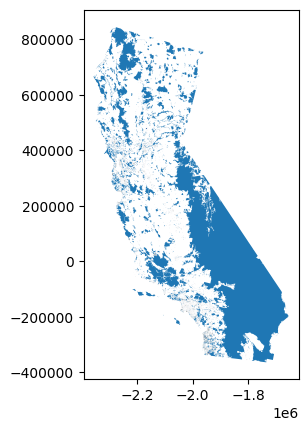

In [7]:
# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

gdf.plot()

In [8]:
output_raster = os.path.join(technology_specific_dir, 'gridcerf_state_level_geothermal_exclusions.tif')

# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=gdf, 
                 value_field="value",
                 output_raster=output_raster)

#### 4.2.1 California Solar Restrictions

In [9]:
# read in shapefile and project to our GRIDCERF projection
gdf = gpd.read_file(ca_solar_shpfile).to_crs(crs=crs)

<Axes: >

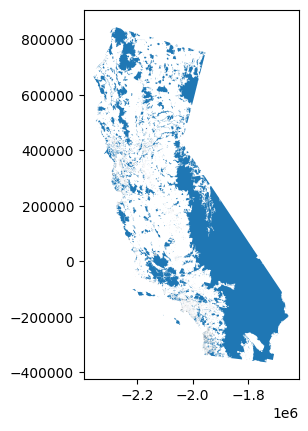

In [10]:
# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

gdf.plot()

In [11]:
output_raster = os.path.join(technology_specific_dir, 'gridcerf_state_level_solar_exclusions.tif')

# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=gdf, 
                 value_field="value",
                 output_raster=output_raster)

#### 4.2.1 California Wind Restrictions

In [12]:
# read in shapefile and project to our GRIDCERF projection
gdf = gpd.read_file(ca_wind_shpfile).to_crs(crs=crs)

<Axes: >

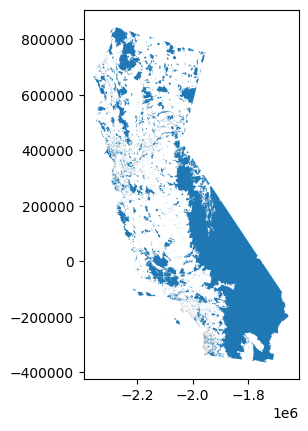

In [13]:
# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

gdf.plot()

In [14]:
output_raster = os.path.join(technology_specific_dir, 'gridcerf_state_level_wind_exclusions.tif')

# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=gdf, 
                 value_field="value",
                 output_raster=output_raster)